In [ ]:
# Install pylibCZIrw and dependencies
#! pip install --upgrade pip
#! pip install "pylibCZIrw~=4.0" "cztile>=0.0,<1.0" matplotlib tqdm scikit-image pooch requests

In [1]:
from pylibCZIrw import czi as pyczi
import json
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
from numpy import ma
import os, sys
from tqdm import tqdm
from tqdm.contrib import itertools as it
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from cellpose import utils
import cv2
from scipy import ndimage
from pathlib import Path
import pandas as pd
from skimage import io, exposure


# show the used python env
print("Using:", sys.executable)

/home/chrism/miniconda3/envs/cellpose3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using: /home/chrism/miniconda3/envs/cellpose3/bin/python


The **`total_bounding_rectangle`** gives us the X and Y dimensions of the CZI, i.e. the (X, Y) of the **`total_bounding_box`**.

Text(0.5, 1.0, 'F4/80')

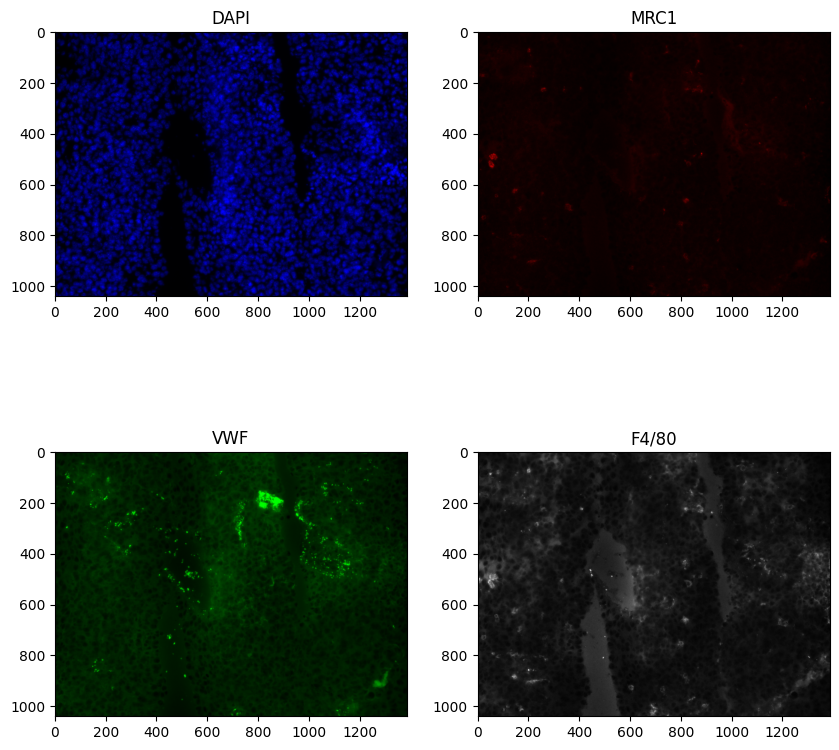

In [2]:
czifile = "Snap-155460.czi"

colors_blue = [(0, 0, 0), (0, 0, 1)]
cm_blue = LinearSegmentedColormap.from_list("Custom", colors_blue, N=255)

colors_red = [(0, 0, 0), (1, 0, 0)]
cm_red = LinearSegmentedColormap.from_list("Custom", colors_red, N=255)

colors_green = [(0, 0, 0), (0, 1, 0)] 
cm_green = LinearSegmentedColormap.from_list("Custom", colors_green, N=255)

colors_white = [(0, 0, 0), (1, 1, 1)] 
cm_white = LinearSegmentedColormap.from_list("Custom", colors_white, N=255)

with pyczi.open_czi(czifile) as czidoc:
    ch0 = czidoc.read(plane={'C': 0})
    dapi = ch0[..., 0]
    ch1 = czidoc.read(plane={'C': 1})
    mrc1 = ch1[..., 0]
    ch2 = czidoc.read(plane={'C': 2})
    vwf = ch2[..., 0]
    ch3 = czidoc.read(plane={'C': 3})
    f480 = ch3[..., 0]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(dapi, cmap=cm_blue)
ax[0,0].set_title("DAPI")

# MRC1
ax[0,1].imshow(mrc1, cmap=cm_red)
ax[0,1].set_title("MRC1")

# VWF
ax[1,0].imshow(vwf, cmap=cm_green)
ax[1,0].set_title("VWF")

# F4/80
ax[1,1].imshow(f480, cmap=cm_white)
ax[1,1].set_title("F4/80")

In [3]:
npyfile = "Snap-155522_c1+2+3+4_seg.npy"
dat = np.load(npyfile, allow_pickle=True).item()
num_cells = dat["masks"].max()
masks = dat["masks"]
slices = utils.find_objects(masks)
num_cells = len(slices)
for i,si in enumerate(slices):
    if si is not None:
        sr,sc = si
        mask = (masks[sr, sc] == (i+1)).astype(np.uint8)
        contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        pvc, pvr = np.concatenate(contours[-2], axis=0).squeeze().T  
        ypix, xpix = np.nonzero(mask)
        min_dist = ((ypix[:,np.newaxis] - pvr)**2 + 
                    (xpix[:,np.newaxis] - pvc)**2).min(axis=1)
        # dist_to_bound[ypix + sr.start, xpix + sc.start] = min_distfig, ax = plt.subplots()


683.2090495672594 511.7547271373163
67.22332953112806 196.6030977967221
425.7325303715101 243.46542135461743
750.1264078161423 270.5588231960496
719.9003458079228 358.69288355799597
374.6276456486768 367.05393811311234
1281.1087652800152 448.2337471177232
1241.578202888671 501.0068424864727
856.5978107767231 527.52112351896
453.52517144719013 813.7502198040899
374.19252152974286 841.6605394130413
494.75535995477856 911.9884119998385
490.2133114035088 930.093004385965
657.679965450582 992.0833024856387
681.7128304189974 1001.6664128813858
817.0785792368395 818.1154818433369
903.273197351776 887.0858641354029
937.9992611484079 995.9234632261936
1240.9111580418248 852.9808580910491
1296.7642865638504 641.4170241446299
1219.0664795769949 392.8298738855901
228.2223392426119 572.3387815616045
317.60815983226877 965.3461650982496
32.294681165475986 482.2537495456383
604.001500013158 959.8557882086685
997.0478463441813 113.50832243855785


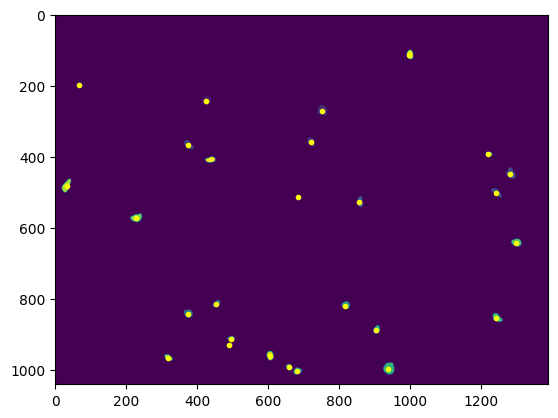

In [4]:
fig, ax = plt.subplots()
ax.imshow(mrc1)
ax.imshow(masks)
cs = ndimage.center_of_mass(mrc1, masks, index=np.arange(0,num_cells))
xs, ys = zip(*cs)
ax.scatter(ys, xs, c="yellow", marker=".")

for y,x in cs:
    print(x,y)


In [5]:
masks

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

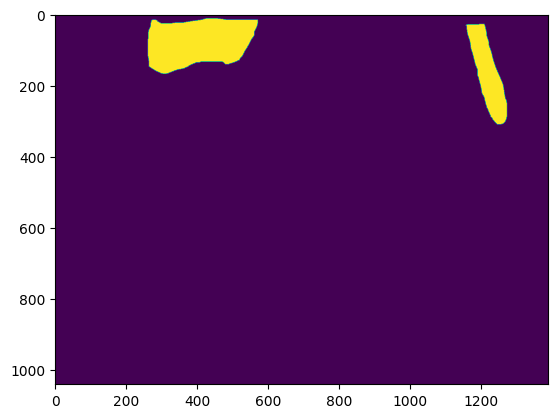

In [6]:
npyfile = "Snap-155522_c1+2+3+4_exclude.npy"
dat = np.load(npyfile, allow_pickle=True).item()
exclude = dat["masks"]>0
plt.imshow(exclude)

Text(0.5, 1.0, 'F4/80')

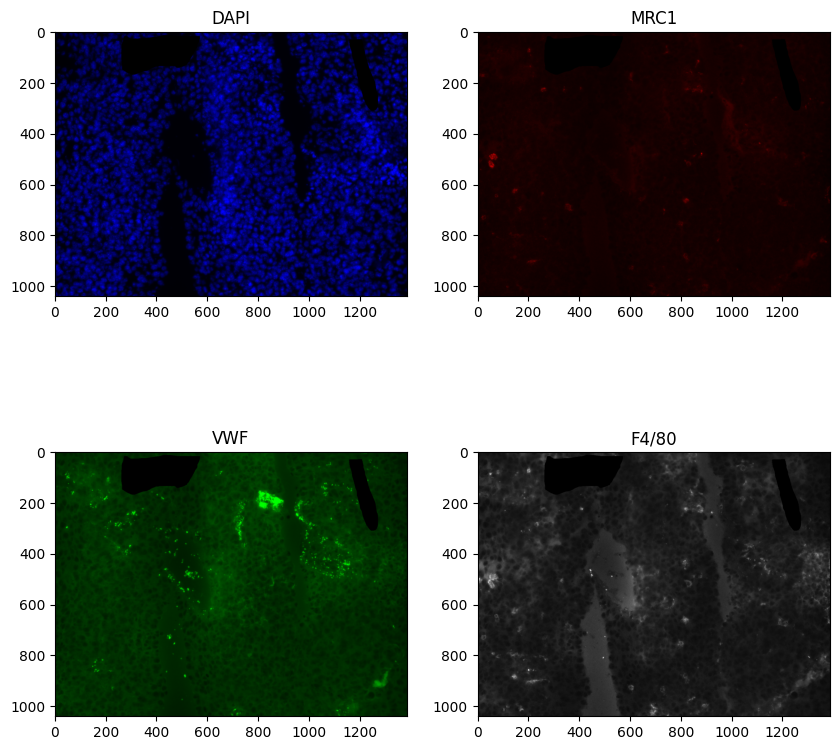

In [7]:
dapi[exclude > 0] = 0
mrc1[exclude > 0] = 0
vwf[exclude > 0] = 0
f480[exclude > 0] = 0

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(dapi, cmap=cm_blue)
ax[0,0].set_title("DAPI")

# MRC1
ax[0,1].imshow(mrc1, cmap=cm_red)
ax[0,1].set_title("MRC1")

# VWF
ax[1,0].imshow(vwf, cmap=cm_green)
ax[1,0].set_title("VWF")

# F4/80
ax[1,1].imshow(f480, cmap=cm_white)
ax[1,1].set_title("F4/80")

In [8]:
slices = utils.find_objects(masks)

for i,si in enumerate(slices):
    if np.any((masks == i+1) & exclude):
        print(f"Cell {i+1} intersecting exclude region. Skipping ...")
        continue
    if si is not None:
        sr,sc = si
        mask = masks[sr, sc] != (i+1)
        dapi_ma = ma.masked_array(dapi[sr, sc], mask)
        mrc1_ma = ma.masked_array(mrc1[sr, sc], mask)
        vwf_ma = ma.masked_array(vwf[sr, sc], mask)
        f480_ma = ma.masked_array(f480[sr, sc], mask)
        mrc1_f480_ratio = mrc1_ma.sum() / f480_ma.sum()
        print(f"MRC1 F4/80 ratio = {mrc1_f480_ratio}")

MRC1 F4/80 ratio = 0.6493602688352292
MRC1 F4/80 ratio = 0.7285401523776163
MRC1 F4/80 ratio = 1.1271164066226067
MRC1 F4/80 ratio = 0.9073466554136833
MRC1 F4/80 ratio = 0.7863334780182303
MRC1 F4/80 ratio = 0.4615633583512658
MRC1 F4/80 ratio = 0.7684273937441478
MRC1 F4/80 ratio = 0.8047161494410408
MRC1 F4/80 ratio = 0.39971802218611363
MRC1 F4/80 ratio = 0.7609014045058555
MRC1 F4/80 ratio = 0.38177670217193593
MRC1 F4/80 ratio = 0.3829583532790809
MRC1 F4/80 ratio = 0.7494759556103576
MRC1 F4/80 ratio = 0.4707804326060039
MRC1 F4/80 ratio = 1.0518032786885245
MRC1 F4/80 ratio = 0.9070571878454889
MRC1 F4/80 ratio = 0.8400467550307342
MRC1 F4/80 ratio = 0.7896604473868993
MRC1 F4/80 ratio = 0.7938651156349537
MRC1 F4/80 ratio = 0.6731673040593467
MRC1 F4/80 ratio = 0.6857034819209145
MRC1 F4/80 ratio = 0.8655229895971809
MRC1 F4/80 ratio = 0.4001748230358578
MRC1 F4/80 ratio = 0.8030643513789582
MRC1 F4/80 ratio = 0.86712621639923
MRC1 F4/80 ratio = 0.5023363820269539


Text(0.5, 1.0, 'F4/80')

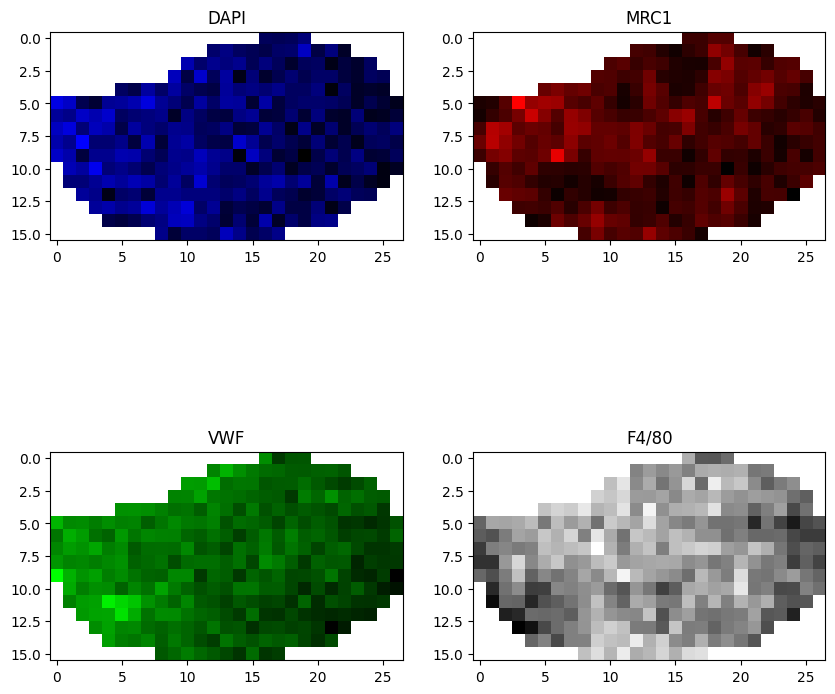

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(dapi_ma, cmap=cm_blue)
ax[0,0].set_title("DAPI")

# MRC1
ax[0,1].imshow(mrc1_ma, cmap=cm_red)
ax[0,1].set_title("MRC1")

# VWF
ax[1,0].imshow(vwf_ma, cmap=cm_green)
ax[1,0].set_title("VWF")

# F4/80
ax[1,1].imshow(f480_ma, cmap=cm_white)
ax[1,1].set_title("F4/80")

In [10]:
radius = 35
x_axis = np.linspace(-1, 1, 2*radius+1)[:, None]
y_axis = np.linspace(-1, 1, 2*radius+1)[None, :]
arr = np.sqrt(x_axis ** 2 + y_axis ** 2)
weights = (arr - arr.max()) * -1

cs = ndimage.center_of_mass(mrc1, masks, index=np.arange(0,num_cells))
# xs, ys = zip(*cs)
for y,x in cs:
    print(x,y)
    x = round(x)
    y = round(y)
    sr = slice(y-radius, y+radius+1)
    sc = slice(x-radius, x+radius+1)
    region = vwf[sr, sc]
    vwf_mean = np.average(region, weights=weights)
    print(vwf_mean)
    


683.7812004510539 524.5410193001056
1066.6386120611128
67.22332953112806 196.6030977967221
811.3360687113172
425.7325303715101 243.46542135461743
619.776960055118
750.1264078161423 270.5588231960496
1200.1081284674967
719.9003458079228 358.69288355799597
1060.918086950851
374.6276456486768 367.05393811311234
639.2658144846772
1281.1087652800152 448.2337471177232
879.8376069548251
1241.578202888671 501.0068424864727
834.0155274937225
856.5978107767231 527.52112351896
775.2163116004334
453.52517144719013 813.7502198040899
637.652852769542
374.19252152974286 841.6605394130413
699.6328281065669
494.75535995477856 911.9884119998385
606.9374967495559
490.2133114035088 930.093004385965
563.0255643961023
657.679965450582 992.0833024856387
688.0416094545254
681.7128304189974 1001.6664128813858
788.4800289980751
817.0785792368395 818.1154818433369
677.8166283573954
903.273197351776 887.0858641354029
678.6806958040486
937.9992611484079 995.9234632261936
676.0850497754349
1240.9111580418248 852.98

TypeError: Axis must be specified when shapes of a and weights differ.

In [ ]:
# load czi
# load cell masks
# load exclude masks
# mask czi channels with exclude masks (set 0)
# discard cells intersecting exclude masks

In [ ]:
vwf_ma.sum()

In [54]:
data_path = Path('C:\\Users\\chrism\\tmp\\Makrophagen Zeiss')

area_pixel = 0.512 * 0.512
cells_path = data_path / "Cells"
czi_path = data_path / "CZI"
exclude_path = data_path / "Exclude"
debug_path = data_path / "debug"
radius = 100 
debug = False
results = []

colors_blue = [(0, 0, 0), (0, 0, 1)]
cm_blue = LinearSegmentedColormap.from_list("Custom", colors_blue, N=255)

colors_red = [(0, 0, 0), (1, 0, 0)]
cm_red = LinearSegmentedColormap.from_list("Custom", colors_red, N=255)

colors_green = [(0, 0, 0), (0, 1, 0)] 
cm_green = LinearSegmentedColormap.from_list("Custom", colors_green, N=255)

colors_white = [(0, 0, 0), (1, 1, 1)] 
cm_white = LinearSegmentedColormap.from_list("Custom", colors_white, N=255)

x_axis = np.linspace(-1, 1, 2*radius+1)[:, None]
y_axis = np.linspace(-1, 1, 2*radius+1)[None, :]
arr = np.sqrt(x_axis ** 2 + y_axis ** 2)
weights = (arr - arr.max()) * -1

for cell_masks_file in cells_path.glob("**/*.npy"):
    print(cell_masks_file)
    slide = cell_masks_file.parent.parts[-1]
    group = cell_masks_file.parent.parts[-2]
    
    exclude_masks = exclude_path / group / slide / cell_masks_file.name
    if not exclude_masks.exists():
        print(f"{exclude_masks} does not exist. Skipping ...")
        continue
        
    czi_file_name = cell_masks_file.name[0:-17] + '.czi'
    czi_file = czi_path / group / slide / czi_file_name
    if not czi_file.exists():
        print(f"{czi_file} does not exist. Skipping ...")
        continue

    cell_seg = np.load(cell_masks_file, allow_pickle=True).item()
    cell_masks = cell_seg["masks"]
    num_cells = cell_masks.max()
    
    exclude_seg = np.load(exclude_masks, allow_pickle=True).item()
    exclude_masks = exclude_seg["masks"] > 0
    
    num_pixels = exclude_masks.shape[0] * exclude_masks.shape[1] - np.count_nonzero(exclude_masks)
    area = num_pixels * area_pixel
    # print(area)
    cells_per_um2 = num_cells / area
    # print(cells_per_um2)

    with pyczi.open_czi(str(czi_file)) as czidoc:
        ch0 = czidoc.read(plane={'C': 0})
        dapi = ch0[..., 0]
        ch1 = czidoc.read(plane={'C': 1})
        mrc1 = ch1[..., 0]
        ch2 = czidoc.read(plane={'C': 2})
        vwf = ch2[..., 0]
        ch3 = czidoc.read(plane={'C': 3})
        f480 = ch3[..., 0]

    if debug:
        # d_slices = utils.find_objects(masks)
        # d_mrc1 = mrc1.copy()
        # for i,si in enumerate(slices):
        #     if si is not None:
        #         sr,sc = si
        #         mask = (masks[sr, sc] == (i+1)).astype(np.uint8)
        #         contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        #         ax.contours(
        #         d_mrc1 = cv2.drawContours(d_mrc1, contours, -1, (0, 255, 0), 2)
                
        plt.ioff()
        fig, ax = plt.subplots(figsize=(13, 10))
        ax.imshow(mrc1, cmap=cm_red)
   
    slices = utils.find_objects(cell_masks)
    cell_centers = ndimage.center_of_mass(mrc1, cell_masks, index=np.arange(1, num_cells + 1))

    for i, (si, (row, col)) in enumerate(zip(slices, cell_centers)): 
        if np.any((cell_masks == i+1) & exclude_masks):
            print(f"Cell {i+1} intersecting exclude region. Skipping ...")
            continue
        if si is not None:
            sr, sc = si
            mask = cell_masks[sr, sc] != (i+1)
            dapi_ma = ma.masked_array(dapi[sr, sc], mask)
            mrc1_ma = ma.masked_array(mrc1[sr, sc], mask)
            vwf_ma = ma.masked_array(vwf[sr, sc], mask)
            f480_ma = ma.masked_array(f480[sr, sc], mask)
            mrc1_f480_ratio = mrc1_ma.sum() / f480_ma.sum()
            f480_mrc1_ratio = f480_ma.sum() / mrc1_ma.sum()
            # print(f"MRC1 F4/80 ratio = {mrc1_f480_ratio}")
        
        corrected_weights = weights
        # print(row, col)
        row = round(row)
        col = round(col)
        
        if row - radius < 0:
            row_start = 0
            corrected_weights = corrected_weights[radius - row:, :]
        else:
            row_start = row - radius

        if row + radius > 1039:
            row_end = 1039
            corrected_weights = corrected_weights[:-1 * ((row + radius + 1) - 1039), :]
        else:
            row_end = row + radius + 1

        if col - radius < 0:
            col_start = 0
            corrected_weights = corrected_weights[:, radius - col:]
        else:
            col_start = col - radius

        if col + radius > 1387:
            col_end = 1387
            corrected_weights = corrected_weights[:, :-1 * ((col + radius + 1) - 1387)]
        else:
            col_end = col + radius + 1
        
        region = vwf[row_start:row_end, col_start:col_end]
        vwf_mean = np.average(region, weights=corrected_weights)
        # print(vwf_mean)

        results_row = {'group': group, 'slide': slide, 'czi': czi_file_name, 'cell_no': i, 'mrc1/f480': mrc1_f480_ratio, 'f480/mrc1': f480_mrc1_ratio, 'mean(vwf)': vwf_mean}
        results.append(results_row)

        if debug:
            ax.text(col, row, str(i), color="white")
            ax.scatter(col, row, c="yellow", marker=".")
            # d_mask = (cell_masks[sr, sc] == (i+1)).astype(np.uint8)
            # d_contours, _ = cv2.findContours(d_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # d_contours, _ = cv2.findContours(d_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            # d_contour = d_contours[0]
            
            # M = cv2.moments(d_contour)
            # x = int(M["m10"] / M["m00"])
            # y = int(M["m01"] / M["m00"])
            
            # xs = [v[0][0] - x for v in d_contour]
            # ys = [-(v[0][1] - y) for v in d_contour]
            
            # ax.plot(xs, ys, color="green")
            

    if debug:
        debug_file_name = cell_masks_file.name + ".png"
        debug_file = debug_path / group / slide / debug_file_name
        debug_file.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(debug_file))
        plt.close(fig)
        plt.ion()
        
df = pd.DataFrame(results)
out_fn = f"results_radius={radius}.xlsx"
df.to_excel(data_path / out_fn)

C:\Users\chrism\tmp\Makrophagen Zeiss\Cells\EX\Makro 1601 EX T\Snap-148534_c1+2+3+4_seg.npy
C:\Users\chrism\tmp\Makrophagen Zeiss\Cells\EX\Makro 1601 EX T\Snap-148535_c1+2+3+4_seg.npy
C:\Users\chrism\tmp\Makrophagen Zeiss\Cells\EX\Makro 1601 EX T\Snap-148536_c1+2+3+4_seg.npy
C:\Users\chrism\tmp\Makrophagen Zeiss\Cells\EX\Makro 1601 EX T\Snap-148537_c1+2+3+4_seg.npy
C:\Users\chrism\tmp\Makrophagen Zeiss\Cells\EX\Makro 1696 EX T\Snap-148478_c1+2+3+4_seg.npy
C:\Users\chrism\tmp\Makrophagen Zeiss\Cells\EX\Makro 1696 EX T\Snap-148479_c1+2+3+4_seg.npy
C:\Users\chrism\tmp\Makrophagen Zeiss\Cells\EX\Makro 1696 EX T\Snap-148480_c1+2+3+4_seg.npy
C:\Users\chrism\tmp\Makrophagen Zeiss\Cells\EX\Makro 1696 EX T\Snap-148481_c1+2+3+4_seg.npy
C:\Users\chrism\tmp\Makrophagen Zeiss\Cells\EX\Makro 1696 EX T\Snap-148482_c1+2+3+4_seg.npy
C:\Users\chrism\tmp\Makrophagen Zeiss\Cells\EX\Makro 1696 EX T\Snap-148483_c1+2+3+4_seg.npy
C:\Users\chrism\tmp\Makrophagen Zeiss\Cells\EX\Makro 1696 EX T\Snap-148484_c1+2+

In [6]:
# nuclei extration

data_path = Path('/home/chrism/datasets/CD8')

area_pixel = 0.512 * 0.512
nuclei_path = data_path / "nuclei"
cells_path = data_path / "cells"
czi_path = data_path / "czi"
exclude_path = data_path / "exclude"
debug_path = data_path / "debug"
classification_path = data_path / "nuclei_classification"

results = []

radius = 100
debug = False

colors_blue = [(0, 0, 0), (0, 0, 1)]
cm_blue = LinearSegmentedColormap.from_list("Custom", colors_blue, N=255)

colors_red = [(0, 0, 0), (1, 0, 0)]
cm_red = LinearSegmentedColormap.from_list("Custom", colors_red, N=255)

colors_green = [(0, 0, 0), (0, 1, 0)] 
cm_green = LinearSegmentedColormap.from_list("Custom", colors_green, N=255)

colors_white = [(0, 0, 0), (1, 1, 1)] 
cm_white = LinearSegmentedColormap.from_list("Custom", colors_white, N=255)

x_axis = np.linspace(-1, 1, 2*radius+1)[:, None]
y_axis = np.linspace(-1, 1, 2*radius+1)[None, :]
arr = np.sqrt(x_axis ** 2 + y_axis ** 2)
weights = (arr - arr.max()) * -1

for nuclei_masks_file in nuclei_path.glob("**/*.npy"):
    print(nuclei_masks_file)
    slide = nuclei_masks_file.parent.parts[-1]
    group = nuclei_masks_file.parent.parts[-2]
    
    exclude_masks = exclude_path / nuclei_masks_file.name
    if not exclude_masks.exists():
        print(f"{exclude_masks} does not exist. Skipping ...")
        continue
        
    czi_file_name = nuclei_masks_file.name[0:-15] + '.czi'
    czi_file = czi_path / czi_file_name
    if not czi_file.exists():
        print(f"{czi_file} does not exist. Skipping ...")
        continue
        
    cells_masks = cells_path / nuclei_masks_file.name
    if not cells_masks.exists():
        print(f"{cells_masks} does not exist. Skipping ...")
        continue
    

    nuclei_seg = np.load(nuclei_masks_file, allow_pickle=True).item()
    nuclei_masks = nuclei_seg["masks"]
    num_nuclei = nuclei_masks.max()
    
    exclude_seg = np.load(exclude_masks, allow_pickle=True).item()
    exclude_masks = exclude_seg["masks"] > 0

    cells_seg = np.load(cells_masks, allow_pickle=True).item()
    cells_masks = cells_seg["masks"]
    num_cells = cells_masks.max()
    
    num_pixels = exclude_masks.shape[0] * exclude_masks.shape[1] - np.count_nonzero(exclude_masks)
    area = num_pixels * area_pixel
    # print(area)
    nuclei_per_um2 = num_nuclei / area
    # print(cells_per_um2)

    with pyczi.open_czi(str(czi_file)) as czidoc:
        ch0 = czidoc.read(plane={'C': 0})
        dapi = ch0[..., 0]
        ch1 = czidoc.read(plane={'C': 1})
        mrc1 = ch1[..., 0]
        ch2 = czidoc.read(plane={'C': 2})
        vwf = ch2[..., 0]
        # ch3 = czidoc.read(plane={'C': 3})
        # f480 = ch3[..., 0]

    if debug:
        # d_slices = utils.find_objects(masks)
        # d_mrc1 = mrc1.copy()
        # for i,si in enumerate(slices):
        #     if si is not None:
        #         sr,sc = si
        #         mask = (masks[sr, sc] == (i+1)).astype(np.uint8)
        #         contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        #         ax.contours(
        #         d_mrc1 = cv2.drawContours(d_mrc1, contours, -1, (0, 255, 0), 2)
                
        plt.ioff()
        fig, ax = plt.subplots(figsize=(13, 10))
        ax.imshow(mrc1, cmap=cm_red)

    # cells_slices = utils.find_objects(cells_masks)
    # cells_centers = ndimage.center_of_mass(mrc1, cells_masks, index=np.arange(1, num_cells + 1))

    # for i, (si, (row, col)) in enumerate(zip(cells_slices, cells_centers)): 
    #     if np.any((cells_masks == i+1) & exclude_masks):
    #         print(f"Cell {i+1} intersecting exclude region. Skipping ...")
    #         continue
    #     if si is not None:
    #         sr, sc = si
    #         cell_mask = cells_masks[sr, sc] != (i+1)
    #         dapi_ma = ma.masked_array(dapi[sr, sc], mask)

    
    slices = utils.find_objects(nuclei_masks)
    nuclei_centers = ndimage.center_of_mass(dapi, nuclei_masks, index=np.arange(1, num_nuclei + 1))

    for i, (si, (row, col)) in enumerate(zip(slices, nuclei_centers)): 
        if np.any((nuclei_masks == i+1) & exclude_masks):
            print(f"Nucleus {i+1} intersecting exclude region. Skipping ...")
            continue
        if np.any((nuclei_masks == i+1) & (cells_masks != 0)):
            nucleus_class = "tcell"
        else:
            nucleus_class = "tumorcell"
        if si is not None:
            sr, sc = si
            mask = nuclei_masks[sr, sc] != (i+1)
            dapi_ma = ma.masked_array(dapi[sr, sc], mask)
            # mrc1_ma = ma.masked_array(mrc1[sr, sc], mask)
            # vwf_ma = ma.masked_array(vwf[sr, sc], mask)
            # f480_ma = ma.masked_array(f480[sr, sc], mask)
            # mrc1_f480_ratio = mrc1_ma.sum() / f480_ma.sum()
            # f480_mrc1_ratio = f480_ma.sum() / mrc1_ma.sum()
            # print(f"MRC1 F4/80 ratio = {mrc1_f480_ratio}")
        
        corrected_weights = weights
        # print(row, col)
        row = round(row)
        col = round(col)
        
        # save image

        im12 = dapi_ma.filled(0)
        im8 = exposure.rescale_intensity(im12, in_range=(0, 2**12), out_range=np.uint8)
        png_file_name = f"{czi_file_name}_{i:0>6}.png"
        png_file_path = classification_path / nucleus_class / png_file_name
        io.imsave(png_file_path, im8)
        results_row = {'czi': czi_file_name, 'nucleus_no': i, 'class': nucleus_class, 'filename': png_file_name, 'mean(dapi)': dapi_ma.mean()}
        results.append(results_row)

        if debug:
            ax.text(col, row, str(i), color="white")
            ax.scatter(col, row, c="yellow", marker=".")
            # d_mask = (cell_masks[sr, sc] == (i+1)).astype(np.uint8)
            # d_contours, _ = cv2.findContours(d_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # d_contours, _ = cv2.findContours(d_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            # d_contour = d_contours[0]
            
            # M = cv2.moments(d_contour)
            # x = int(M["m10"] / M["m00"])
            # y = int(M["m01"] / M["m00"])
            
            # xs = [v[0][0] - x for v in d_contour]
            # ys = [-(v[0][1] - y) for v in d_contour]
            
            # ax.plot(xs, ys, color="green")
            

    if debug:
        debug_file_name = nuclei_masks_file.name + ".png"
        debug_file = debug_path / debug_file_name
        debug_file.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(debug_file))
        plt.close(fig)
        plt.ion()
        
df = pd.DataFrame(results)
out_fn = f"results_nuclei.xlsx"
df.to_excel(data_path / out_fn)

/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12357 HS3ST1___Snap-156983_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/HS6ST1___CD8 HS6ST1 12368___Snap-156908_c1+2+3_seg.npy
Nucleus 1022 intersecting exclude region. Skipping ...
Nucleus 1072 intersecting exclude region. Skipping ...
Nucleus 1104 intersecting exclude region. Skipping ...
Nucleus 1124 intersecting exclude region. Skipping ...
Nucleus 1161 intersecting exclude region. Skipping ...
Nucleus 1364 intersecting exclude region. Skipping ...
Nucleus 1392 intersecting exclude region. Skipping ...
Nucleus 1413 intersecting exclude region. Skipping ...
/home/chrism/datasets/CD8/nuclei/siHPSE___CD8 siHPSE left hole 03 1___Snap-144244_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1765 NDST4___Snap-147525_c1+2+3_seg.npy
Nucleus 3 intersecting exclude region. Skipping ...
Nucleus 43 intersecting exclude region. Skipping ...
Nucleus 51 intersecting exclude region. Skipping ...
Nucleus 64 intersecting exclude region. Skip

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147525.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147525.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147525.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147525.czi_000004.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

Nucleus 256 intersecting exclude region. Skipping ...
Nucleus 291 intersecting exclude region. Skipping ...
Nucleus 319 intersecting exclude region. Skipping ...
Nucleus 324 intersecting exclude region. Skipping ...
Nucleus 334 intersecting exclude region. Skipping ...
Nucleus 354 intersecting exclude region. Skipping ...
Nucleus 466 intersecting exclude region. Skipping ...


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147525.czi_000446.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147525.czi_000447.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147525.czi_000448.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147525.czi_000449.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

Nucleus 498 intersecting exclude region. Skipping ...
Nucleus 516 intersecting exclude region. Skipping ...
Nucleus 532 intersecting exclude region. Skipping ...
Nucleus 539 intersecting exclude region. Skipping ...
Nucleus 544 intersecting exclude region. Skipping ...
Nucleus 550 intersecting exclude region. Skipping ...
Nucleus 565 intersecting exclude region. Skipping ...
Nucleus 626 intersecting exclude region. Skipping ...


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147525.czi_000675.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147525.czi_000676.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147525.czi_000677.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147525.czi_000679.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1763 NDST4___Snap-147908_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon right hole 1___Snap-144570_c1+2+3_seg.npy
/home/chrism/datasets/CD8/czi/siCon___CD8 siCon right hole 1___Snap-144570.czi does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 12176 NDST4___Snap-155327_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 12176 NDST4___Snap-155326_c1+2+3_seg.npy
/home/chrism/datasets/CD8/cells/NDST4___CD8 12176 NDST4___Snap-155326_c1+2+3_seg.npy does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon 07 left hole 1___Snap-144489_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1763 NDST4___Snap-147615_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147615.czi_000004.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147615.czi_000006.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147615.czi_000008.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147615.czi_000009.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1763 NDST4___Snap-147907_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/WT___CD8 1756 WT___Snap-147406_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147406.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147406.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147406.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147406.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147406.c

/home/chrism/datasets/CD8/nuclei/WT___CD8 1759 WT___Snap-147740_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1759 WT___Snap-147740.czi_000084.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1759 WT___Snap-147740.czi_000134.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1759 WT___Snap-147740.czi_000259.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1759 WT___Snap-147740.czi_000348.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1759 WT___Snap-147740.c

/home/chrism/datasets/CD8/nuclei/WT___CD8 1757 WT___Snap-147704_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147704.czi_000138.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147704.czi_000202.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147704.czi_000236.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147704.czi_000278.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147704.c

/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1754 NDST4___Snap-147513_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147513.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147513.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147513.czi_000013.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147513.czi_000025.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/WT___CD8 12170 WT___Snap-155329_c1+2+3_seg.npy
/home/chrism/datasets/CD8/cells/WT___CD8 12170 WT___Snap-155329_c1+2+3_seg.npy does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/siHPSE___CD8 siHPSE 16 (-) 1___Snap-144447_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1763 NDST4___Snap-147904_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12359 NDST1___Snap-157085_c1+2+3_seg.npy
Nucleus 1102 intersecting exclude region. Skipping ...
Nucleus 1129 intersecting exclude region. Skipping ...
Nucleus 1156 intersecting exclude region. Skipping ...
Nucleus 1161 intersecting exclude region. Skipping ...
Nucleus 1174 intersecting exclude region. Skipping ...
Nucleus 1175 intersecting exclude region. Skipping ...
Nucleus 1201 intersecting exclude region. Skipping ...
Nucleus 1207 intersecting exclude region. Skipping ...
Nucleus 1226 intersecting exclude region. Skipping ...
Nucleus 1258 intersecting exclude region. Skipping ...


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147707.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147707.czi_000004.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147707.czi_000014.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147707.czi_000018.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147707.c

/home/chrism/datasets/CD8/nuclei/EXT1___CD8 12187 EXT1___Snap-155288_c1+2+3_seg.npy
/home/chrism/datasets/CD8/czi/EXT1___CD8 12187 EXT1___Snap-155288.czi does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon right hole 1___Snap-144635_c1+2+3_seg.npy
/home/chrism/datasets/CD8/czi/siCon___CD8 siCon right hole 1___Snap-144635.czi does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/WT___CD8 1755 WT___Snap-147780_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147780.czi_000098.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147780.czi_000099.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147780.czi_000101.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147780.czi_000102.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147780.c

/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12355 HS3ST1___Snap-157022_c1+2+3_seg.npy
Nucleus 1524 intersecting exclude region. Skipping ...
Nucleus 1536 intersecting exclude region. Skipping ...
/home/chrism/datasets/CD8/nuclei/siHPSE___CD8 siHPSE left hole 03 1___Snap-144247_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE left hole 03 1___Snap-144247.czi_000324.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE left hole 03 1___Snap-144247.czi_000885.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE left hole 03 1___Snap-144247.czi_000930.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147609.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_cla

/home/chrism/datasets/CD8/nuclei/EX___CD8 1601 EX___Snap-147609_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147609.czi_000053.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147609.czi_000054.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147609.czi_000057.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147609.czi_000058.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147609.c

/home/chrism/datasets/CD8/nuclei/EX___CD8 1761 EX___Snap-147713_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147713.czi_000040.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147713.czi_000041.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147713.czi_000042.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147713.czi_000045.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147713.c

/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12175 HS3ST1___Snap-155260_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/EX___CD8 1696 EX___Snap-147666_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147666.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147666.czi_000004.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147666.czi_000007.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147666.czi_000011.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147666.c

/home/chrism/datasets/CD8/nuclei/siHPSE___CD8 siHPSE 16 (-) 1___Snap-144445_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1754 NDST4___Snap-147505_c1+2+3_seg.npy
Nucleus 117 intersecting exclude region. Skipping ...
Nucleus 143 intersecting exclude region. Skipping ...


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147505.czi_000010.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147505.czi_000015.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147505.czi_000017.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147505.czi_000018.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

Nucleus 342 intersecting exclude region. Skipping ...
Nucleus 367 intersecting exclude region. Skipping ...
Nucleus 469 intersecting exclude region. Skipping ...
Nucleus 478 intersecting exclude region. Skipping ...
Nucleus 516 intersecting exclude region. Skipping ...
Nucleus 540 intersecting exclude region. Skipping ...


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147505.czi_000471.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147505.czi_000478.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147505.czi_000506.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147505.czi_000514.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

Nucleus 591 intersecting exclude region. Skipping ...
Nucleus 643 intersecting exclude region. Skipping ...
Nucleus 690 intersecting exclude region. Skipping ...


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147505.czi_000712.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147505.czi_000721.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147505.czi_000722.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147505.czi_000731.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/EX___CD8 1601 EX___Snap-147961_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/WT___CD8 12170 WT___Snap-155334_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/siHPSE___CD8 siHPSE left hole 03 1___Snap-144240_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/HS6ST1___CD8 HS6ST1 12368___Snap-156912_c1+2+3_seg.npy
Nucleus 40 intersecting exclude region. Skipping ...
Nucleus 62 intersecting exclude region. Skipping ...
Nucleus 192 intersecting exclude region. Skipping ...
Nucleus 195 intersecting exclude region. Skipping ...
Nucleus 218 intersecting exclude region. Skipping ...
Nucleus 266 intersecting exclude region. Skipping ...
Nucleus 267 intersecting exclude region. Skipping ...
Nucleus 330 intersecting exclude region. Skipping ...
Nucleus 370 intersecting exclude region. Skipping ...
Nucleus 487 intersecting exclude region. Skipping ...
Nucleus 571 intersecting exclude region. Skipping ...
Nucleus 593 intersecting exclude region. Skipping ...
Nucleus 61

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147454.czi_000006.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147454.czi_000008.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147454.czi_000009.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147454.czi_000010.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147454.c

/home/chrism/datasets/CD8/nuclei/WT___CD8 1755 WT___Snap-147784_c1+2+3_seg.npy
/home/chrism/datasets/CD8/exclude/WT___CD8 1755 WT___Snap-147784_c1+2+3_seg.npy does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12175 HS3ST1___Snap-155267_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12356 HS3ST1___Snap-156980_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12361 NDST1___Snap-157081_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/siHPSE___CD8 siHPSE left hole 03 1___Snap-144252_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE left hole 03 1___Snap-144252.czi_000458.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/CD8/nuclei/EXT1___CD8 12187 EXT1___Snap-155279_c1+2+3_seg.npy
/home/chrism/datasets/CD8/czi/EXT1___CD8 12187 EXT1___Snap-155279.czi does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/EX___CD8 1760 KL EX___Snap-154274_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/HS6ST1___CD8 HS6ST1 12370___Snap-156929_c1+2+3_seg.npy
Nucleus 507 intersecting exclude region. Skipping ...
Nucleus 729 intersecting exclude region. Skipping ...
Nucleus 778 intersecting exclude region. Skipping ...
Nucleus 814 intersecting exclude region. Skipping ...
Nucleus 874 intersecting exclude region. Skipping ...
Nucleus 948 intersecting exclude region. Skipping ...
Nucleus 972 intersecting exclude region. Skipping ...
Nucleus 1054 intersecting exclude region. Skipping ...
Nucleus 1212 intersecting exclude region. Skipping ...
Nucleus 1227 intersecting exclude region. Skipping ...
Nucleus 1237 intersecting exclude region. Skipping ...
/home/chrism/datasets/CD8/nuclei/WT___CD8 1757 WT

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147731.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147731.czi_000011.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147731.czi_000015.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147731.czi_000023.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147731.c

/home/chrism/datasets/CD8/nuclei/EX___CD8 1760 KL EX___Snap-154280_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12355 HS3ST1___Snap-157027_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/WT___CD8 12170 WT___Snap-155330_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/WT___CD8 12178 WT___Snap-155257_c1+2+3_seg.npy
Nucleus 22 intersecting exclude region. Skipping ...
Nucleus 26 intersecting exclude region. Skipping ...
Nucleus 55 intersecting exclude region. Skipping ...
/home/chrism/datasets/CD8/nuclei/HS6ST1___CD8 HS6ST1 12368___Snap-156911_c1+2+3_seg.npy
Nucleus 305 intersecting exclude region. Skipping ...
Nucleus 365 intersecting exclude region. Skipping ...
Nucleus 385 intersecting exclude region. Skipping ...
Nucleus 401 intersecting exclude region. Skipping ...
Nucleus 461 intersecting exclude region. Skipping ...
Nucleus 504 intersecting exclude region. Skipping ...
Nucleus 541 intersecting exclude region. Skipping ...
Nucleus 600 intersecting exclude region. Skip

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147577.czi_000036.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147577.czi_000098.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147577.czi_000100.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147577.czi_000104.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147577.c

/home/chrism/datasets/CD8/nuclei/EX___CD8 1761 EX___Snap-147692_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147692.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147692.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147692.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147692.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147692.c

/home/chrism/datasets/CD8/nuclei/WT___CD8 12172 WT___Snap-155219_c1+2+3_seg.npy
Nucleus 43 intersecting exclude region. Skipping ...
Nucleus 64 intersecting exclude region. Skipping ...
Nucleus 112 intersecting exclude region. Skipping ...
Nucleus 120 intersecting exclude region. Skipping ...
Nucleus 146 intersecting exclude region. Skipping ...
Nucleus 165 intersecting exclude region. Skipping ...
Nucleus 192 intersecting exclude region. Skipping ...
Nucleus 206 intersecting exclude region. Skipping ...
Nucleus 231 intersecting exclude region. Skipping ...
Nucleus 242 intersecting exclude region. Skipping ...
Nucleus 292 intersecting exclude region. Skipping ...
Nucleus 317 intersecting exclude region. Skipping ...
Nucleus 320 intersecting exclude region. Skipping ...
Nucleus 336 intersecting exclude region. Skipping ...
Nucleus 362 intersecting exclude region. Skipping ...
Nucleus 373 intersecting exclude region. Skipping ...
Nucleus 405 intersecting exclude region. Skipping ...
Nucl

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147639.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147639.czi_000016.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147639.czi_000017.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147639.czi_000018.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147639.c

/home/chrism/datasets/CD8/nuclei/EXT1___CD8 23433 EXT1___Snap-156153_c1+2+3_seg.npy
/home/chrism/datasets/CD8/czi/EXT1___CD8 23433 EXT1___Snap-156153.czi does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/HS6ST1___CD8 HS6ST1 12363___Snap-156939_c1+2+3_seg.npy
/home/chrism/datasets/CD8/exclude/HS6ST1___CD8 HS6ST1 12363___Snap-156939_c1+2+3_seg.npy does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12360 NDST1___Snap-157043_c1+2+3_seg.npy
Nucleus 43 intersecting exclude region. Skipping ...
Nucleus 198 intersecting exclude region. Skipping ...
Nucleus 665 intersecting exclude region. Skipping ...
Nucleus 687 intersecting exclude region. Skipping ...
Nucleus 699 intersecting exclude region. Skipping ...
Nucleus 750 intersecting exclude region. Skipping ...
Nucleus 785 intersecting exclude region. Skipping ...
Nucleus 809 intersecting exclude region. Skipping ...
Nucleus 866 intersecting exclude region. Skipping ...
/home/chrism/datasets/CD8/nuclei/siCon__

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147504.czi_000004.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147504.czi_000005.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147504.czi_000018.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147504.czi_000019.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

Nucleus 305 intersecting exclude region. Skipping ...
Nucleus 449 intersecting exclude region. Skipping ...
Nucleus 490 intersecting exclude region. Skipping ...
Nucleus 494 intersecting exclude region. Skipping ...
Nucleus 523 intersecting exclude region. Skipping ...


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147504.czi_000483.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147504.czi_000494.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147504.czi_000499.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147504.czi_000505.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon 07 left hole 1___Snap-144492_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12359 NDST1___Snap-157089_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/HS6ST1___CD8 HS6ST1 12367___Snap-156890_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon right hole 1___Snap-144579_c1+2+3_seg.npy
/home/chrism/datasets/CD8/czi/siCon___CD8 siCon right hole 1___Snap-144579.czi does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12356 HS3ST1___Snap-156972_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 12177 NDST4___Snap-155343_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/WT___CD8 1755 WT___Snap-147448_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147448.czi_000015.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147448.czi_000016.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147448.czi_000037.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147448.czi_000056.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147448.c

/home/chrism/datasets/CD8/nuclei/WT___CD8 1759 WT___Snap-154258_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1763 NDST4___Snap-147903_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/WT___CD8 1757 WT___Snap-147700_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147700.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147700.czi_000011.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147700.czi_000013.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147700.czi_000016.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147700.c

/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12361 NDST1___Snap-157078_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12360 NDST1___Snap-157036_c1+2+3_seg.npy
Nucleus 38 intersecting exclude region. Skipping ...
Nucleus 73 intersecting exclude region. Skipping ...
Nucleus 79 intersecting exclude region. Skipping ...
Nucleus 100 intersecting exclude region. Skipping ...
Nucleus 124 intersecting exclude region. Skipping ...
Nucleus 149 intersecting exclude region. Skipping ...
Nucleus 160 intersecting exclude region. Skipping ...
Nucleus 205 intersecting exclude region. Skipping ...
Nucleus 206 intersecting exclude region. Skipping ...
Nucleus 439 intersecting exclude region. Skipping ...
Nucleus 486 intersecting exclude region. Skipping ...
Nucleus 506 intersecting exclude region. Skipping ...
/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12175 HS3ST1___Snap-155268_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon 20 (-) 1___Snap-144400_c1+2+3_seg.npy
/home/

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1764 NDST4___Snap-147642.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1764 NDST4___Snap-147642.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1764 NDST4___Snap-147642.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1764 NDST4___Snap-147642.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/HS6ST1___CD8 HS6ST1 12369___Snap-156920_c1+2+3_seg.npy
Nucleus 4 intersecting exclude region. Skipping ...
Nucleus 59 intersecting exclude region. Skipping ...
Nucleus 69 intersecting exclude region. Skipping ...
Nucleus 76 intersecting exclude region. Skipping ...
Nucleus 77 intersecting exclude region. Skipping ...
Nucleus 97 intersecting exclude region. Skipping ...
Nucleus 148 intersecting exclude region. Skipping ...
Nucleus 179 intersecting exclude region. Skipping ...
Nucleus 255 intersecting exclude region. Skipping ...
Nucleus 309 intersecting exclude region. Skipping ...
Nucleus 349 intersecting exclude region. Skipping ...
Nucleus 597 intersecting exclude region. Skipping ...
/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12359 NDST1___Snap-157091_c1+2+3_seg.npy
Nucleus 647 intersecting exclude region. Skipping ...
Nucleus 694 intersecting exclude region. Skipping ...
Nucleus 868 intersecting exclude region. Skipping ...
Nucleus 910 intersectin

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE left hole 03 1___Snap-144249.czi_000040.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE left hole 03 1___Snap-144249.czi_000526.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE left hole 03 1___Snap-144249.czi_000547.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE left hole 03 1___Snap-144249.czi_000580.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datas

/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1765 NDST4___Snap-147530_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147530.czi_000068.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147530.czi_000069.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147530.czi_000070.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147530.czi_000071.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1764 NDST4___Snap-147630_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12356 HS3ST1___Snap-156976_c1+2+3_seg.npy
Nucleus 92 intersecting exclude region. Skipping ...
Nucleus 141 intersecting exclude region. Skipping ...
Nucleus 150 intersecting exclude region. Skipping ...
Nucleus 394 intersecting exclude region. Skipping ...
Nucleus 490 intersecting exclude region. Skipping ...
Nucleus 525 intersecting exclude region. Skipping ...
Nucleus 556 intersecting exclude region. Skipping ...
Nucleus 566 intersecting exclude region. Skipping ...
Nucleus 640 intersecting exclude region. Skipping ...
Nucleus 822 intersecting exclude region. Skipping ...
Nucleus 843 intersecting exclude region. Skipping ...
Nucleus 870 intersecting exclude region. Skipping ...
Nucleus 902 intersecting exclude region. Skipping ...
Nucleus 913 intersecting exclude region. Skipping ...
Nucleus 956 intersecting exclude region. Skipping ...
/home/chrism/datas

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147641.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147641.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147641.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147641.czi_000004.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147641.c

/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12362 NDST1___Snap-157063_c1+2+3_seg.npy
Nucleus 78 intersecting exclude region. Skipping ...
Nucleus 176 intersecting exclude region. Skipping ...
Nucleus 225 intersecting exclude region. Skipping ...
Nucleus 242 intersecting exclude region. Skipping ...
Nucleus 375 intersecting exclude region. Skipping ...
Nucleus 394 intersecting exclude region. Skipping ...
Nucleus 644 intersecting exclude region. Skipping ...
Nucleus 705 intersecting exclude region. Skipping ...
/home/chrism/datasets/CD8/nuclei/siHPSE___CD8 siHPSE 03 left edge 1___Snap-144380_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE 03 left edge 1___Snap-144380.czi_000592.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12355 HS3ST1___Snap-157023_c1+2+3_seg.npy
Nucleus 900 intersecting exclude region. Skipping ...
Nucleus 1114 intersecting exclude region. Skipping ...
Nucleus 1229 intersecting exclude region. Skipping ...
Nucleus 1315 intersecting exclude region. Skipping ...
Nucleus 1395 intersecting exclude region. Skipping ...
Nucleus 1434 intersecting exclude region. Skipping ...
Nucleus 1460 intersecting exclude region. Skipping ...
Nucleus 1466 intersecting exclude region. Skipping ...
Nucleus 1491 intersecting exclude region. Skipping ...
Nucleus 1495 intersecting exclude region. Skipping ...
Nucleus 1530 intersecting exclude region. Skipping ...
/home/chrism/datasets/CD8/nuclei/EX___CD8 1601 EX___Snap-147614_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147614.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147614.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147614.czi_000009.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147614.czi_000011.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147614.c

/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon 05 left edge 1___Snap-144667_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1762 NDST4___Snap-147659_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147659.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147659.czi_000013.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147659.czi_000015.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147659.czi_000017.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/NDST4___CD8 12177 NDST4___Snap-155342_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 12177 NDST4___Snap-155335_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/EXT1___CD8 12189 EXT1___Snap-155305_c1+2+3_seg.npy
/home/chrism/datasets/CD8/czi/EXT1___CD8 12189 EXT1___Snap-155305.czi does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12373 HS3ST1___Snap-157002_c1+2+3_seg.npy
Nucleus 303 intersecting exclude region. Skipping ...
Nucleus 350 intersecting exclude region. Skipping ...
Nucleus 520 intersecting exclude region. Skipping ...
Nucleus 618 intersecting exclude region. Skipping ...
Nucleus 648 intersecting exclude region. Skipping ...
Nucleus 673 intersecting exclude region. Skipping ...
Nucleus 906 intersecting exclude region. Skipping ...
/home/chrism/datasets/CD8/nuclei/WT___CD8 12172 WT___Snap-155220_c1+2+3_seg.npy
Nucleus 66 intersecting exclude region. Skipping ...
Nucleus 103 intersecting exclude region. Skipp

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147775.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147775.czi_000005.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147775.czi_000006.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147775.czi_000007.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147775.c

/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1754 NDST4___Snap-147849_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1763 NDST4___Snap-147626_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147626.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147626.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147626.czi_000005.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147626.czi_000009.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1763 NDST4___Snap-147610_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147610.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147610.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147610.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147610.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1763 NDST4___Snap-147614_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147614.czi_000020.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147614.czi_000024.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147614.czi_000025.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147614.czi_000027.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/EX___CD8 1761 EX___Snap-147704_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147704.czi_000110.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147704.czi_000113.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147704.czi_000114.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147704.czi_000115.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147704.c

/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12356 HS3ST1___Snap-156979_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12356 HS3ST1___Snap-156982_c1+2+3_seg.npy
Nucleus 33 intersecting exclude region. Skipping ...
Nucleus 54 intersecting exclude region. Skipping ...
Nucleus 74 intersecting exclude region. Skipping ...
Nucleus 94 intersecting exclude region. Skipping ...
Nucleus 98 intersecting exclude region. Skipping ...
Nucleus 99 intersecting exclude region. Skipping ...
Nucleus 102 intersecting exclude region. Skipping ...
Nucleus 131 intersecting exclude region. Skipping ...
Nucleus 157 intersecting exclude region. Skipping ...
Nucleus 183 intersecting exclude region. Skipping ...
Nucleus 185 intersecting exclude region. Skipping ...
Nucleus 187 intersecting exclude region. Skipping ...
Nucleus 205 intersecting exclude region. Skipping ...
Nucleus 227 intersecting exclude region. Skipping ...
Nucleus 283 intersecting exclude region. Skipping ...
Nucleus 318 intersec

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147612.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147612.czi_000008.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147612.czi_000010.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147612.czi_000021.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12361 NDST1___Snap-157071_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1754 NDST4___Snap-147842_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/EX___CD8 1760 EX___Snap-147592_c1+2+3_seg.npy
Nucleus 1 intersecting exclude region. Skipping ...
Nucleus 22 intersecting exclude region. Skipping ...
Nucleus 23 intersecting exclude region. Skipping ...
Nucleus 26 intersecting exclude region. Skipping ...
Nucleus 33 intersecting exclude region. Skipping ...
Nucleus 37 intersecting exclude region. Skipping ...
Nucleus 38 intersecting exclude region. Skipping ...
Nucleus 50 intersecting exclude region. Skipping ...
Nucleus 52 intersecting exclude region. Skipping ...
Nucleus 58 intersecting exclude region. Skipping ...
Nucleus 64 intersecting exclude region. Skipping ...
Nucleus 68 intersecting exclude region. Skipping ...
Nucleus 71 intersecting exclude region. Skipping ...
Nucleus 72 intersecting exclude region. Skipping ...
Nucleus 8

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_000018.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_000054.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_000055.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_000080.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.c

Nucleus 172 intersecting exclude region. Skipping ...
Nucleus 173 intersecting exclude region. Skipping ...
Nucleus 190 intersecting exclude region. Skipping ...
Nucleus 200 intersecting exclude region. Skipping ...
Nucleus 205 intersecting exclude region. Skipping ...
Nucleus 224 intersecting exclude region. Skipping ...
Nucleus 252 intersecting exclude region. Skipping ...
Nucleus 267 intersecting exclude region. Skipping ...
Nucleus 277 intersecting exclude region. Skipping ...
Nucleus 299 intersecting exclude region. Skipping ...
Nucleus 312 intersecting exclude region. Skipping ...
Nucleus 320 intersecting exclude region. Skipping ...
Nucleus 329 intersecting exclude region. Skipping ...
Nucleus 340 intersecting exclude region. Skipping ...
Nucleus 358 intersecting exclude region. Skipping ...
Nucleus 359 intersecting exclude region. Skipping ...
Nucleus 364 intersecting exclude region. Skipping ...
Nucleus 378 intersecting exclude region. Skipping ...
Nucleus 389 intersecting exc

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_000275.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_000282.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_000317.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_000324.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.c

Nucleus 415 intersecting exclude region. Skipping ...
Nucleus 428 intersecting exclude region. Skipping ...
Nucleus 468 intersecting exclude region. Skipping ...
Nucleus 505 intersecting exclude region. Skipping ...
Nucleus 549 intersecting exclude region. Skipping ...
Nucleus 578 intersecting exclude region. Skipping ...
Nucleus 611 intersecting exclude region. Skipping ...


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_000564.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_000584.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_000663.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.c

Nucleus 649 intersecting exclude region. Skipping ...
Nucleus 680 intersecting exclude region. Skipping ...
Nucleus 727 intersecting exclude region. Skipping ...
Nucleus 745 intersecting exclude region. Skipping ...
Nucleus 764 intersecting exclude region. Skipping ...
Nucleus 816 intersecting exclude region. Skipping ...
Nucleus 878 intersecting exclude region. Skipping ...


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_000822.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_000908.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_000928.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_001046.png is a low contrast image
  io.imsave(png_file_path, im8)


Nucleus 907 intersecting exclude region. Skipping ...
Nucleus 935 intersecting exclude region. Skipping ...
Nucleus 1015 intersecting exclude region. Skipping ...
Nucleus 1057 intersecting exclude region. Skipping ...
Nucleus 1089 intersecting exclude region. Skipping ...
Nucleus 1091 intersecting exclude region. Skipping ...
Nucleus 1105 intersecting exclude region. Skipping ...
Nucleus 1117 intersecting exclude region. Skipping ...
Nucleus 1118 intersecting exclude region. Skipping ...


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_001059.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_001083.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_001105.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_001108.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.c

Nucleus 1151 intersecting exclude region. Skipping ...
Nucleus 1174 intersecting exclude region. Skipping ...
Nucleus 1185 intersecting exclude region. Skipping ...
Nucleus 1203 intersecting exclude region. Skipping ...
Nucleus 1211 intersecting exclude region. Skipping ...
Nucleus 1236 intersecting exclude region. Skipping ...
Nucleus 1259 intersecting exclude region. Skipping ...
Nucleus 1284 intersecting exclude region. Skipping ...
/home/chrism/datasets/CD8/nuclei/EX___CD8 1760 EX___Snap-147959_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_001295.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_001344.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_001354.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1760 EX___Snap-147592.czi_001355.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/CD8/nuclei/EXT1___CD8 23432 EXT1___Snap-156146_c1+2+3_seg.npy
/home/chrism/datasets/CD8/czi/EXT1___CD8 23432 EXT1___Snap-156146.czi does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/EX___CD8 1696 EX___Snap-147937_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/EXT1___CD8 12188 EXT1___Snap-155293_c1+2+3_seg.npy
/home/chrism/datasets/CD8/czi/EXT1___CD8 12188 EXT1___Snap-155293.czi does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon 05 left edge 1___Snap-146244_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1763 NDST4___Snap-147901_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/WT___CD8 1755 WT___Snap-147455_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147455.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147455.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147455.czi_000020.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147455.czi_000021.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147455.c

/home/chrism/datasets/CD8/nuclei/WT___CD8 1756 WT___Snap-147381_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147381.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147381.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147381.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147381.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147381.c

/home/chrism/datasets/CD8/nuclei/NDST4___CD8 12177 NDST4___Snap-155346_c1+2+3_seg.npy
Nucleus 17 intersecting exclude region. Skipping ...
Nucleus 22 intersecting exclude region. Skipping ...
Nucleus 23 intersecting exclude region. Skipping ...
Nucleus 35 intersecting exclude region. Skipping ...
Nucleus 38 intersecting exclude region. Skipping ...
Nucleus 39 intersecting exclude region. Skipping ...
Nucleus 42 intersecting exclude region. Skipping ...
Nucleus 55 intersecting exclude region. Skipping ...
Nucleus 68 intersecting exclude region. Skipping ...
Nucleus 71 intersecting exclude region. Skipping ...
Nucleus 79 intersecting exclude region. Skipping ...
Nucleus 80 intersecting exclude region. Skipping ...
Nucleus 87 intersecting exclude region. Skipping ...
Nucleus 89 intersecting exclude region. Skipping ...
Nucleus 90 intersecting exclude region. Skipping ...
Nucleus 103 intersecting exclude region. Skipping ...
Nucleus 107 intersecting exclude region. Skipping ...
Nucleus 110

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147514.czi_000035.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147514.czi_000066.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147514.czi_000073.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1754 NDST4___Snap-147514.czi_000088.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/HS6ST1___CD8 HS6ST1 12370___Snap-156928_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/EXT1___CD8 12179 EXT1___Snap-155269_c1+2+3_seg.npy
/home/chrism/datasets/CD8/czi/EXT1___CD8 12179 EXT1___Snap-155269.czi does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 12177 NDST4___Snap-155337_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/EX___CD8 1761 EX___Snap-147700_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147700.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147700.czi_000005.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147700.czi_000006.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147700.czi_000007.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147700.c

/home/chrism/datasets/CD8/nuclei/WT___CD8 1757 WT___Snap-147709_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147709.czi_000121.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147709.czi_000124.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147709.czi_000125.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147709.czi_000131.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147709.c

/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1754 NDST4___Snap-147841_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/EX___CD8 1760 EX___Snap-147932_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon 05 left edge 1___Snap-144674_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1763 NDST4___Snap-147616_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147616.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147616.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147616.czi_000004.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147616.czi_000008.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12354 HS3ST1___Snap-156993_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon right hole 1___Snap-144632_c1+2+3_seg.npy
/home/chrism/datasets/CD8/czi/siCon___CD8 siCon right hole 1___Snap-144632.czi does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1763 NDST4___Snap-147609_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147609.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147609.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147609.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147609.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

Nucleus 671 intersecting exclude region. Skipping ...
Nucleus 771 intersecting exclude region. Skipping ...
Nucleus 809 intersecting exclude region. Skipping ...
Nucleus 856 intersecting exclude region. Skipping ...
Nucleus 879 intersecting exclude region. Skipping ...


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147609.czi_000864.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147609.czi_000865.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147609.czi_000866.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147609.czi_000867.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

Nucleus 920 intersecting exclude region. Skipping ...
Nucleus 939 intersecting exclude region. Skipping ...
Nucleus 982 intersecting exclude region. Skipping ...
Nucleus 1008 intersecting exclude region. Skipping ...
Nucleus 1034 intersecting exclude region. Skipping ...
Nucleus 1097 intersecting exclude region. Skipping ...
Nucleus 1118 intersecting exclude region. Skipping ...


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147609.czi_001082.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147609.czi_001083.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147609.czi_001084.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147609.czi_001085.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/NDST4___CD8 12177 NDST4___Snap-155345_c1+2+3_seg.npy
Nucleus 346 intersecting exclude region. Skipping ...
Nucleus 395 intersecting exclude region. Skipping ...
Nucleus 446 intersecting exclude region. Skipping ...
Nucleus 477 intersecting exclude region. Skipping ...
Nucleus 486 intersecting exclude region. Skipping ...
Nucleus 507 intersecting exclude region. Skipping ...
Nucleus 553 intersecting exclude region. Skipping ...
Nucleus 569 intersecting exclude region. Skipping ...
Nucleus 591 intersecting exclude region. Skipping ...
Nucleus 606 intersecting exclude region. Skipping ...
Nucleus 622 intersecting exclude region. Skipping ...
Nucleus 627 intersecting exclude region. Skipping ...
Nucleus 636 intersecting exclude region. Skipping ...
Nucleus 645 intersecting exclude region. Skipping ...
Nucleus 649 intersecting exclude region. Skipping ...
Nucleus 674 intersecting exclude region. Skipping ...
Nucleus 680 intersecting exclude region. Skipping 

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147778.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147778.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147778.czi_000005.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147778.czi_000008.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147778.c

/home/chrism/datasets/CD8/nuclei/EX___CD8 1696 EX___Snap-147948_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/EX___CD8 1760 EX___Snap-147930_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/HS6ST1___CD8 HS6ST1 12367___Snap-156891_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon 05 left edge 1___Snap-144670_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/WT___CD8 12170 WT___Snap-155327_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/EX___CD8 1761 EX___Snap-147693_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147693.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147693.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147693.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147693.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147693.c

/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1762 NDST4___Snap-147675_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147675.czi_000068.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147675.czi_000078.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147675.czi_000091.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147675.czi_000099.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/EX___CD8 1601 EX___Snap-147964_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12359 NDST1___Snap-157094_c1+2+3_seg.npy
Nucleus 186 intersecting exclude region. Skipping ...
Nucleus 249 intersecting exclude region. Skipping ...
Nucleus 328 intersecting exclude region. Skipping ...
Nucleus 458 intersecting exclude region. Skipping ...
Nucleus 493 intersecting exclude region. Skipping ...
Nucleus 566 intersecting exclude region. Skipping ...
Nucleus 570 intersecting exclude region. Skipping ...
Nucleus 618 intersecting exclude region. Skipping ...
Nucleus 755 intersecting exclude region. Skipping ...
Nucleus 795 intersecting exclude region. Skipping ...
Nucleus 825 intersecting exclude region. Skipping ...
Nucleus 842 intersecting exclude region. Skipping ...
Nucleus 877 intersecting exclude region. Skipping ...
Nucleus 884 intersecting exclude region. Skipping ...
Nucleus 967 intersecting exclude region. Skipping ...
Nucleus 1012 intersecting

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147705.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147705.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147705.czi_000005.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147705.czi_000006.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147705.c

/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12181 HS3ST1___Snap-155287_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/EX___CD8 1601 EX___Snap-147616_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147616.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147616.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147616.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147616.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147616.c

/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon 07 left hole 1___Snap-144487_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/siHPSE___CD8 siHPSE 06 1___Snap-144326_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/HS6ST1___CD8 HS6ST1 12363___Snap-156943_c1+2+3_seg.npy
/home/chrism/datasets/CD8/exclude/HS6ST1___CD8 HS6ST1 12363___Snap-156943_c1+2+3_seg.npy does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon right hole 1___Snap-144567_c1+2+3_seg.npy
/home/chrism/datasets/CD8/czi/siCon___CD8 siCon right hole 1___Snap-144567.czi does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon 11 right edge 1___Snap-144525_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12360 NDST1___Snap-157030_c1+2+3_seg.npy
Nucleus 425 intersecting exclude region. Skipping ...
Nucleus 491 intersecting exclude region. Skipping ...
Nucleus 535 intersecting exclude region. Skipping ...
Nucleus 603 intersecting exclude region. Skipping ...
Nucleus 646 i

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147447.czi_000004.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147447.czi_000011.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147447.czi_000020.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147447.czi_000028.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147447.c

/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1764 NDST4___Snap-147896_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/EX___CD8 1601 EX___Snap-147963_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/siHPSE___CD8 siHPSE 16 (-) 1___Snap-144246_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12361 NDST1___Snap-157082_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12181 HS3ST1___Snap-155281_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12356 HS3ST1___Snap-156981_c1+2+3_seg.npy
Nucleus 19 intersecting exclude region. Skipping ...
Nucleus 60 intersecting exclude region. Skipping ...
Nucleus 71 intersecting exclude region. Skipping ...
Nucleus 104 intersecting exclude region. Skipping ...
Nucleus 135 intersecting exclude region. Skipping ...
Nucleus 167 intersecting exclude region. Skipping ...
Nucleus 174 intersecting exclude region. Skipping ...
Nucleus 217 intersecting exclude region. Skipping ...
Nucleus 247 intersecting exclude region. Skipping ...


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147640.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147640.czi_000020.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147640.czi_000021.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147640.czi_000024.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147640.c

/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1762 NDST4___Snap-147924_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/siHPSE___CD8 siHPSE 06 1___Snap-144323_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1762 NDST4___Snap-147677_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147677.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147677.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147677.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147677.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon 05 left edge 1___Snap-144661_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12363 NDST1___Snap-157048_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12361 NDST1___Snap-157074_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/HS6ST1___CD8 HS6ST1 12370___Snap-156933_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/WT___CD8 12174 WT___Snap-155313_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/EX___CD8 1761 EX___Snap-147696_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147696.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147696.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147696.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147696.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147696.c

/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon 05 left edge 1___Snap-146254_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/EXT1___CD8 12189 EXT1___Snap-155314_c1+2+3_seg.npy
/home/chrism/datasets/CD8/czi/EXT1___CD8 12189 EXT1___Snap-155314.czi does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/WT___CD8 1756 WT___Snap-147391_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147391.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147391.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147391.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147391.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147391.c

/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12175 HS3ST1___Snap-155269_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/EX___CD8 1761 EX___Snap-147697_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147697.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147697.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147697.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147697.czi_000004.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147697.c

/home/chrism/datasets/CD8/nuclei/EX___CD8 1696 EX___Snap-147642_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147642.czi_000138.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147642.czi_000139.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147642.czi_000141.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147642.czi_000142.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147642.c

/home/chrism/datasets/CD8/nuclei/WT___CD8 1756 WT___Snap-147408_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147408.czi_000054.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147408.czi_000055.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147408.czi_000056.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147408.czi_000057.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147408.c

/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon 11 right edge 1___Snap-144522_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/HS6ST1___CD8 HS6ST1 12367___Snap-156887_c1+2+3_seg.npy
Nucleus 4 intersecting exclude region. Skipping ...
Nucleus 22 intersecting exclude region. Skipping ...
Nucleus 43 intersecting exclude region. Skipping ...
Nucleus 44 intersecting exclude region. Skipping ...
Nucleus 57 intersecting exclude region. Skipping ...
Nucleus 60 intersecting exclude region. Skipping ...
Nucleus 71 intersecting exclude region. Skipping ...
Nucleus 82 intersecting exclude region. Skipping ...
Nucleus 92 intersecting exclude region. Skipping ...
Nucleus 94 intersecting exclude region. Skipping ...
Nucleus 99 intersecting exclude region. Skipping ...
Nucleus 113 intersecting exclude region. Skipping ...
Nucleus 126 intersecting exclude region. Skipping ...
Nucleus 129 intersecting exclude region. Skipping ...
Nucleus 144 intersecting exclude region. Skipping ...
Nucleus 154 inters

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147418.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147418.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147418.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147418.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147418.c

/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12355 HS3ST1___Snap-157021_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/HS6ST1___CD8 HS6ST1 12367___Snap-156884_c1+2+3_seg.npy
Nucleus 1399 intersecting exclude region. Skipping ...
Nucleus 1568 intersecting exclude region. Skipping ...
Nucleus 1603 intersecting exclude region. Skipping ...
Nucleus 1640 intersecting exclude region. Skipping ...
Nucleus 1652 intersecting exclude region. Skipping ...
Nucleus 1669 intersecting exclude region. Skipping ...
Nucleus 1681 intersecting exclude region. Skipping ...
Nucleus 1709 intersecting exclude region. Skipping ...
Nucleus 1728 intersecting exclude region. Skipping ...
Nucleus 1752 intersecting exclude region. Skipping ...
Nucleus 1825 intersecting exclude region. Skipping ...
/home/chrism/datasets/CD8/nuclei/siHPSE___CD8 siHPSE 06 1___Snap-144328_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/siHPSE___CD8 siHPSE 06 1___Snap-144329_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/WT___CD8 175

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147402.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147402.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147402.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147402.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1756 WT___Snap-147402.c

/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12356 HS3ST1___Snap-156970_c1+2+3_seg.npy
Nucleus 19 intersecting exclude region. Skipping ...
Nucleus 23 intersecting exclude region. Skipping ...
Nucleus 27 intersecting exclude region. Skipping ...
Nucleus 30 intersecting exclude region. Skipping ...
Nucleus 39 intersecting exclude region. Skipping ...
Nucleus 49 intersecting exclude region. Skipping ...
Nucleus 52 intersecting exclude region. Skipping ...
Nucleus 55 intersecting exclude region. Skipping ...
Nucleus 83 intersecting exclude region. Skipping ...
Nucleus 96 intersecting exclude region. Skipping ...
Nucleus 103 intersecting exclude region. Skipping ...
Nucleus 107 intersecting exclude region. Skipping ...
Nucleus 117 intersecting exclude region. Skipping ...
Nucleus 125 intersecting exclude region. Skipping ...
Nucleus 126 intersecting exclude region. Skipping ...
Nucleus 129 intersecting exclude region. Skipping ...
Nucleus 134 intersecting exclude region. Skipping ...
Nucl

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147615.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147615.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147615.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147615.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147615.c

/home/chrism/datasets/CD8/nuclei/siHPSE___CD8 siHPSE 16 (-) 1___Snap-144443_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE 16 (-) 1___Snap-144443.czi_000141.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE 16 (-) 1___Snap-144443.czi_001039.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE 16 (-) 1___Snap-144443.czi_001043.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE 16 (-) 1___Snap-144443.czi_001064.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/CD8/nuclei/HS6ST1___CD8 HS6ST1 12363___Snap-156963_c1+2+3_seg.npy
/home/chrism/datasets/CD8/exclude/HS6ST1___CD8 HS6ST1 12363___Snap-156963_c1+2+3_seg.npy does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12360 NDST1___Snap-157035_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon 05 left edge 1___Snap-144669_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/WT___CD8 1755 WT___Snap-147783_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147783.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147783.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147783.czi_000006.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147783.czi_000022.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147783.c

/home/chrism/datasets/CD8/nuclei/siHPSE___CD8 siHPSE 06 1___Snap-144320_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1762 NDST4___Snap-147680_c1+2+3_seg.npy
Nucleus 36 intersecting exclude region. Skipping ...
Nucleus 58 intersecting exclude region. Skipping ...
Nucleus 114 intersecting exclude region. Skipping ...


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147680.czi_000007.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147680.czi_000013.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147680.czi_000015.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147680.czi_000019.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

Nucleus 402 intersecting exclude region. Skipping ...
Nucleus 416 intersecting exclude region. Skipping ...
Nucleus 461 intersecting exclude region. Skipping ...


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147680.czi_000468.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147680.czi_000482.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147680.czi_000513.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147680.czi_000516.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12356 HS3ST1___Snap-156975_c1+2+3_seg.npy
Nucleus 26 intersecting exclude region. Skipping ...
Nucleus 47 intersecting exclude region. Skipping ...
Nucleus 55 intersecting exclude region. Skipping ...
Nucleus 115 intersecting exclude region. Skipping ...
Nucleus 135 intersecting exclude region. Skipping ...
Nucleus 140 intersecting exclude region. Skipping ...
Nucleus 150 intersecting exclude region. Skipping ...
Nucleus 162 intersecting exclude region. Skipping ...
Nucleus 187 intersecting exclude region. Skipping ...
Nucleus 198 intersecting exclude region. Skipping ...
Nucleus 209 intersecting exclude region. Skipping ...
Nucleus 236 intersecting exclude region. Skipping ...
Nucleus 243 intersecting exclude region. Skipping ...
Nucleus 253 intersecting exclude region. Skipping ...
Nucleus 265 intersecting exclude region. Skipping ...
Nucleus 283 intersecting exclude region. Skipping ...
Nucleus 295 intersecting exclude region. Skipping .

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147781.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147781.czi_000016.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147781.czi_000018.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147781.czi_000030.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147781.c

/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12183 HS3ST1___Snap-155299_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/HS6ST1___CD8 HS6ST1 12370___Snap-156932_c1+2+3_seg.npy
Nucleus 454 intersecting exclude region. Skipping ...
Nucleus 538 intersecting exclude region. Skipping ...
Nucleus 602 intersecting exclude region. Skipping ...
Nucleus 702 intersecting exclude region. Skipping ...
Nucleus 769 intersecting exclude region. Skipping ...
Nucleus 964 intersecting exclude region. Skipping ...
Nucleus 1090 intersecting exclude region. Skipping ...
/home/chrism/datasets/CD8/nuclei/siHPSE___CD8 siHPSE left hole 03 1___Snap-144248_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE left hole 03 1___Snap-144248.czi_000839.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147610.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147610.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147610.czi_000004.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 

/home/chrism/datasets/CD8/nuclei/EX___CD8 1601 EX___Snap-147610_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147610.czi_000041.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147610.czi_000042.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147610.czi_000044.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147610.czi_000048.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1601 EX___Snap-147610.c

/home/chrism/datasets/CD8/nuclei/EXT1___CD8 12188 EXT1___Snap-155303_c1+2+3_seg.npy
/home/chrism/datasets/CD8/czi/EXT1___CD8 12188 EXT1___Snap-155303.czi does not exist. Skipping ...
/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12361 NDST1___Snap-157080_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/WT___CD8 12172 WT___Snap-155218_c1+2+3_seg.npy
Nucleus 97 intersecting exclude region. Skipping ...
Nucleus 149 intersecting exclude region. Skipping ...
Nucleus 154 intersecting exclude region. Skipping ...
Nucleus 159 intersecting exclude region. Skipping ...
Nucleus 175 intersecting exclude region. Skipping ...
Nucleus 191 intersecting exclude region. Skipping ...
Nucleus 193 intersecting exclude region. Skipping ...
Nucleus 205 intersecting exclude region. Skipping ...
Nucleus 212 intersecting exclude region. Skipping ...
Nucleus 236 intersecting exclude region. Skipping ...
Nucleus 237 intersecting exclude region. Skipping ...
Nucleus 243 intersecting exclude region. Skipping ...
Nucl

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147450.czi_000089.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147450.czi_000148.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147450.czi_000150.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147450.czi_000155.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147450.c

/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12361 NDST1___Snap-157072_c1+2+3_seg.npy
Nucleus 193 intersecting exclude region. Skipping ...
Nucleus 227 intersecting exclude region. Skipping ...
Nucleus 268 intersecting exclude region. Skipping ...
Nucleus 435 intersecting exclude region. Skipping ...
Nucleus 473 intersecting exclude region. Skipping ...
/home/chrism/datasets/CD8/nuclei/EX___CD8 1601 EX___Snap-147962_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12363 NDST1___Snap-157050_c1+2+3_seg.npy
Nucleus 96 intersecting exclude region. Skipping ...
Nucleus 113 intersecting exclude region. Skipping ...
Nucleus 125 intersecting exclude region. Skipping ...
Nucleus 166 intersecting exclude region. Skipping ...
Nucleus 203 intersecting exclude region. Skipping ...
Nucleus 213 intersecting exclude region. Skipping ...
Nucleus 248 intersecting exclude region. Skipping ...
Nucleus 284 intersecting exclude region. Skipping ...
Nucleus 307 intersecting exclude region. Skippin

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147613.czi_000008.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147613.czi_000009.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147613.czi_000022.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1763 NDST4___Snap-147613.czi_000032.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/WT___CD8 12174 WT___Snap-155241_c1+2+3_seg.npy
Nucleus 310 intersecting exclude region. Skipping ...
Nucleus 409 intersecting exclude region. Skipping ...
Nucleus 414 intersecting exclude region. Skipping ...
Nucleus 451 intersecting exclude region. Skipping ...
Nucleus 795 intersecting exclude region. Skipping ...
Nucleus 813 intersecting exclude region. Skipping ...
Nucleus 846 intersecting exclude region. Skipping ...
Nucleus 920 intersecting exclude region. Skipping ...
Nucleus 1200 intersecting exclude region. Skipping ...
Nucleus 1268 intersecting exclude region. Skipping ...
Nucleus 1314 intersecting exclude region. Skipping ...
Nucleus 1325 intersecting exclude region. Skipping ...
Nucleus 1347 intersecting exclude region. Skipping ...
Nucleus 1354 intersecting exclude region. Skipping ...
Nucleus 1359 intersecting exclude region. Skipping ...
Nucleus 1376 intersecting exclude region. Skipping ...
Nucleus 1383 intersecting exclude region. Skippi

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147456.czi_000001.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147456.czi_000032.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147456.czi_000048.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147456.czi_000064.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147456.c

/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12355 HS3ST1___Snap-157009_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12360 NDST1___Snap-157044_c1+2+3_seg.npy
Nucleus 41 intersecting exclude region. Skipping ...
Nucleus 77 intersecting exclude region. Skipping ...
Nucleus 118 intersecting exclude region. Skipping ...
Nucleus 269 intersecting exclude region. Skipping ...
Nucleus 289 intersecting exclude region. Skipping ...
Nucleus 298 intersecting exclude region. Skipping ...
/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12355 HS3ST1___Snap-157013_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/HS3ST1___CD8 12373 HS3ST1___Snap-157006_c1+2+3_seg.npy
Nucleus 52 intersecting exclude region. Skipping ...
Nucleus 121 intersecting exclude region. Skipping ...
Nucleus 156 intersecting exclude region. Skipping ...
Nucleus 182 intersecting exclude region. Skipping ...
Nucleus 212 intersecting exclude region. Skipping ...
Nucleus 216 intersecting exclude region. Skipping ...
Nucle

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147676.czi_000062.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147676.czi_000191.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147676.czi_000441.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1762 NDST4___Snap-147676.czi_000496.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/siCon___CD8 siCon 20 (-) 1___Snap-144391_c1+2+3_seg.npy
/home/chrism/datasets/CD8/nuclei/NDST1___CD8 12362 NDST1___Snap-157062_c1+2+3_seg.npy
Nucleus 18 intersecting exclude region. Skipping ...
Nucleus 44 intersecting exclude region. Skipping ...
Nucleus 51 intersecting exclude region. Skipping ...
Nucleus 63 intersecting exclude region. Skipping ...
Nucleus 88 intersecting exclude region. Skipping ...
Nucleus 134 intersecting exclude region. Skipping ...
Nucleus 167 intersecting exclude region. Skipping ...
Nucleus 268 intersecting exclude region. Skipping ...
Nucleus 326 intersecting exclude region. Skipping ...
Nucleus 337 intersecting exclude region. Skipping ...
Nucleus 355 intersecting exclude region. Skipping ...
Nucleus 378 intersecting exclude region. Skipping ...
Nucleus 399 intersecting exclude region. Skipping ...
Nucleus 418 intersecting exclude region. Skipping ...
Nucleus 441 intersecting exclude region. Skipping ...
Nucleus 475 intersec

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147644.czi_000000.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147644.czi_000002.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147644.czi_000003.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147644.czi_000007.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1696 EX___Snap-147644.c

/home/chrism/datasets/CD8/nuclei/WT___CD8 1755 WT___Snap-147446_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147446.czi_000063.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147446.czi_000065.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147446.czi_000072.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147446.czi_000075.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1755 WT___Snap-147446.c

/home/chrism/datasets/CD8/nuclei/NDST4___CD8 1765 NDST4___Snap-147533_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147533.czi_000061.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147533.czi_000062.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147533.czi_000063.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___CD8 1765 NDST4___Snap-147533.czi_000064.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/NDST4___

/home/chrism/datasets/CD8/nuclei/siHPSE___CD8 siHPSE left hole 03 1___Snap-144251_c1+2+3_seg.npy


/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE left hole 03 1___Snap-144251.czi_000082.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE left hole 03 1___Snap-144251.czi_000084.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE left hole 03 1___Snap-144251.czi_000204.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/siHPSE___CD8 siHPSE left hole 03 1___Snap-144251.czi_000312.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datas

/home/chrism/datasets/CD8/nuclei/WT___CD8 12174 WT___Snap-155244_c1+2+3_seg.npy
Nucleus 35 intersecting exclude region. Skipping ...
Nucleus 51 intersecting exclude region. Skipping ...
Nucleus 68 intersecting exclude region. Skipping ...
Nucleus 79 intersecting exclude region. Skipping ...
Nucleus 107 intersecting exclude region. Skipping ...
Nucleus 124 intersecting exclude region. Skipping ...
Nucleus 127 intersecting exclude region. Skipping ...
Nucleus 172 intersecting exclude region. Skipping ...
Nucleus 219 intersecting exclude region. Skipping ...
Nucleus 226 intersecting exclude region. Skipping ...
Nucleus 240 intersecting exclude region. Skipping ...
Nucleus 262 intersecting exclude region. Skipping ...
Nucleus 323 intersecting exclude region. Skipping ...
Nucleus 325 intersecting exclude region. Skipping ...
Nucleus 358 intersecting exclude region. Skipping ...
Nucleus 377 intersecting exclude region. Skipping ...
Nucleus 386 intersecting exclude region. Skipping ...
Nucleu

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147708.czi_000011.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147708.czi_000017.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147708.czi_000025.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147708.czi_000029.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/EX___CD8 1761 EX___Snap-147708.c

/home/chrism/datasets/CD8/nuclei/WT___CD8 12172 WT___Snap-155215_c1+2+3_seg.npy
Nucleus 656 intersecting exclude region. Skipping ...
Nucleus 694 intersecting exclude region. Skipping ...
Nucleus 704 intersecting exclude region. Skipping ...
Nucleus 726 intersecting exclude region. Skipping ...
Nucleus 753 intersecting exclude region. Skipping ...
Nucleus 812 intersecting exclude region. Skipping ...
Nucleus 839 intersecting exclude region. Skipping ...
Nucleus 862 intersecting exclude region. Skipping ...
Nucleus 903 intersecting exclude region. Skipping ...
Nucleus 1027 intersecting exclude region. Skipping ...
Nucleus 1083 intersecting exclude region. Skipping ...
Nucleus 1145 intersecting exclude region. Skipping ...
Nucleus 1188 intersecting exclude region. Skipping ...
Nucleus 1255 intersecting exclude region. Skipping ...
Nucleus 1341 intersecting exclude region. Skipping ...
Nucleus 1411 intersecting exclude region. Skipping ...
Nucleus 1433 intersecting exclude region. Skippin

/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147728.czi_000014.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147728.czi_000020.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147728.czi_000038.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147728.czi_000040.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_273205/1165646105.py:145: UserWarning: /home/chrism/datasets/CD8/nuclei_classification/tumorcell/WT___CD8 1757 WT___Snap-147728.c

/home/chrism/datasets/CD8/nuclei/HS6ST1___CD8 HS6ST1 12368___Snap-156906_c1+2+3_seg.npy
Nucleus 139 intersecting exclude region. Skipping ...
Nucleus 173 intersecting exclude region. Skipping ...
Nucleus 211 intersecting exclude region. Skipping ...
Nucleus 253 intersecting exclude region. Skipping ...
Nucleus 336 intersecting exclude region. Skipping ...
Nucleus 397 intersecting exclude region. Skipping ...
Nucleus 425 intersecting exclude region. Skipping ...
Nucleus 442 intersecting exclude region. Skipping ...
Nucleus 460 intersecting exclude region. Skipping ...
Nucleus 490 intersecting exclude region. Skipping ...
Nucleus 493 intersecting exclude region. Skipping ...
Nucleus 503 intersecting exclude region. Skipping ...
Nucleus 514 intersecting exclude region. Skipping ...
Nucleus 534 intersecting exclude region. Skipping ...
Nucleus 557 intersecting exclude region. Skipping ...
Nucleus 606 intersecting exclude region. Skipping ...
Nucleus 631 intersecting exclude region. Skippin

KeyboardInterrupt: 

In [4]:
region.shape

NameError: name 'region' is not defined

In [ ]:
corrected_weights.shape

In [ ]:
weights.shape